In [2]:
import pandas as pd
import DataLoading
import NN_classes
import torch
import matplotlib.pyplot as plt
import numpy as np
import NN_evaluation

In [3]:
#Import the original data for plotting
sc = "sc01"
period = "2030"
folder = "../Data/3-bus_DC_fy_LB/"
all_executions = DataLoading.list_executions(folder=folder,per = period,sc=sc)
len(all_executions)
executions = all_executions[0:40]
te_s = 0.3
val_s = 0.3
outp = "SystemCosts"
hyperloop_name = "test_LB_3-bus_DC_0.3_v0.3_0_10"

In [13]:
df_losses = pd.read_csv(f"Loss_results_csv/{hyperloop_name}.csv",index_col = 0)

dfs_in, dfs_out = DataLoading.load_data_ext_out(folder, all_executions, period, sc, None)
# dfs_inter_j = DataLoading.join_frames_inter_layer(dfs_inter,all_executions)
# dfs_inter_j = DataLoading.trim_columns_to_common(dfs_inter_j)
# Convert to pytorch tensors
ts_in, ts_out = DataLoading.split_tr_val_te_ext_out(dfs_in, dfs_out, None, all_executions, te_s, val_s)
d_ft_in, d_ft_out,maxs = DataLoading.concat_and_normalize_ext_out(ts_in, ts_out, None, all_executions)

input_size = dfs_in["Full_Network"].shape[1]

#Extract fy sets
t_in_fy, t_out_fy, maxs = DataLoading.concat_all_exec_fy(dfs_in, dfs_out, None,all_executions)

input_f_sc01_Full_Network_2030.csv
14
input_f_sc01_Network_Line_In_Node_1_Node_2_cac1_2030.csv
14
input_f_sc01_Network_Line_In_Node_1_Node_2_cac2_2030.csv
14
input_f_sc01_Network_Line_In_Node_1_Node_2_cac3_2030.csv
14
input_f_sc01_Network_Line_In_Node_1_Node_3_cac1_2030.csv
14
input_f_sc01_Network_Line_In_Node_1_Node_3_cac2_2030.csv
14
input_f_sc01_Network_Line_In_Node_1_Node_3_cac3_2030.csv
14
input_f_sc01_Network_Line_In_Node_2_Node_3_cac1_2030.csv
14
input_f_sc01_Network_Line_In_Node_2_Node_3_cac2_2030.csv
14
input_f_sc01_Network_Line_In_Node_2_Node_3_cac3_2030.csv
14


[28, 42, 22, 30, 15]
OE_1000hours_(3, 1)h_64e_0.0025lr_0dor_Falsero_64bs_0ill_FalseMAE min_val
trained_models/test_LB_3-bus_DC_0.3_v0.3_0_10/min_val/model_OE_1000hours_(3, 1)h_64e_0.0025lr_0dor_Falsero_64bs_0ill_FalseMAE.pth


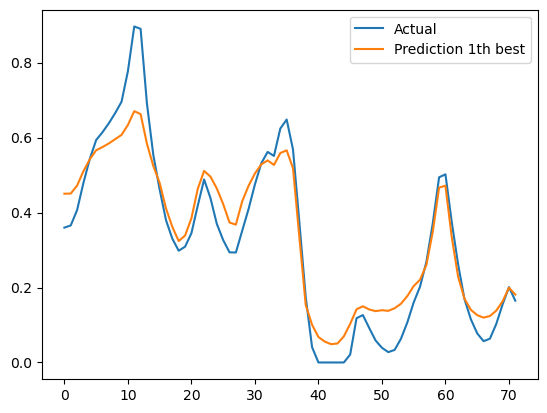

In [40]:
#Visualisation of multiple executions in input order
f = df_losses.Nb_hours_used >=1

loss_to_sort = "fy_l_mse"
s = 5000
e=s+72
ex = all_executions[0]


#ex_in = torch.nan_to_num(ts_in[data_part][ex]/maxs["in"])
ex_in = torch.nan_to_num(dfs_in[ex].to_numpy()/maxs["in"])
ex_out = dfs_out[ex].sum(axis=1).to_numpy()



plt.plot(ex_out[s:e]/maxs["out"],label = "Actual")

for xth_best in [1]: 
    row = NN_evaluation.find_xthbest_model_params_from_df(df_losses[f],loss_to_sort,xth_best)
    m = NN_evaluation.create_model_and_load_state_from_row(row,input_size,30,hyperloop_name,cluster_run=False)
    prediction = m(ex_in.float())[0].detach().numpy()
    plt.plot(prediction[s:e],label = f"Prediction {xth_best}th best")
plt.legend()

In [6]:
i=0
all_counts = pd.DataFrame()

for ex in all_executions:
    ex_in = torch.nan_to_num(dfs_in[ex].to_numpy()/maxs["in"])
    lb_actual = dfs_out[ex].sum(axis=1).to_numpy().flatten()
    
    lb_est =  m(ex_in.float())[0].detach().numpy().flatten()
    
    both_positive_count = np.sum((lb_est > 0) & (lb_actual > 0))
    both_negative_count = np.sum((lb_est < 0) & (lb_actual < 0))
    opposite_sign_count = np.sum((lb_est * lb_actual) < 0)
    BZ = np.sum((lb_est==0) & (lb_actual == 0))
    OZ = np.sum((lb_est * lb_actual) == 0)


    row_lb = pd.DataFrame({"exec":ex,"BP":both_positive_count, "BN":both_negative_count,"OS":opposite_sign_count,"OZ":OZ,"BZ":BZ,}, index = [i])
    all_counts = pd.concat([all_counts,row_lb],axis=0)
    i+=1
    

In [7]:
all_counts.sum()

exec    Network_Existing_Generation_FullNetwork_Line_I...
BP                                                  28266
BN                                                      0
OS                                                      0
OZ                                                    126
BZ                                                      0
dtype: object

In [42]:
#calculate loss manually to see if coherent 

data_part = "test"
loss = torch.nn.MSELoss()

prediction = m(d_ft_in[data_part].float())[0]
loss(prediction.squeeze(),d_ft_out[data_part])

tensor(5.7853e-09, dtype=torch.float64, grad_fn=<MseLossBackward0>)

In [40]:
manual_loss_mse = np.mean([(p.item()-a)**2  for p,a in zip(prediction.squeeze(),d_ft_out[data_part])])
manual_loss_mae = np.mean(np.abs([(p.item()-a)  for p,a in zip(prediction.squeeze(),d_ft_out[data_part])]))

In [41]:
manual_loss_mse,manual_loss_mae

(5.785276570340915e-09, 5.5119475880945136e-05)

In [22]:
prediction.squeeze()

tensor([1.1114e-04, 1.1932e-04, 1.1292e-04,  ..., 2.3428e-06, 2.9865e-04,
        3.4909e-04], grad_fn=<SqueezeBackward0>)